In [1]:
import numpy as np
import gym
import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt

import actor_critic
from simple_env import SimpleEnv

In [2]:
gamma = 0.9
max_episode_steps = 300

x_min = np.array( [ 1 ] )
reward_func = lambda x : -np.sum( np.square( x - x_min ) )
low  = [ -10.0 ]
high = [ +10.0 ]

env_init_fun = lambda : SimpleEnv(reward_func=reward_func, low=low, high=high, max_steps=max_episode_steps )
env = actor_critic.EnvBatch(env_init_fun)

In [3]:
actor = actor_critic.ActorMLP(env=env, scale_model_inputs=False, activation='relu')
critic = actor_critic.CriticMLP(env=env, scale_model_inputs=False, activation='relu')

ac = actor_critic.ActorCritic(
                 env=env,
                 actor=actor, 
                 critic=critic,
                 entropy_coef=0.001,
                 actor_learning_rate=0.001,
                 critic_learning_rate=0.01, 
                 gamma=gamma
                )

### Train the models and display the progress

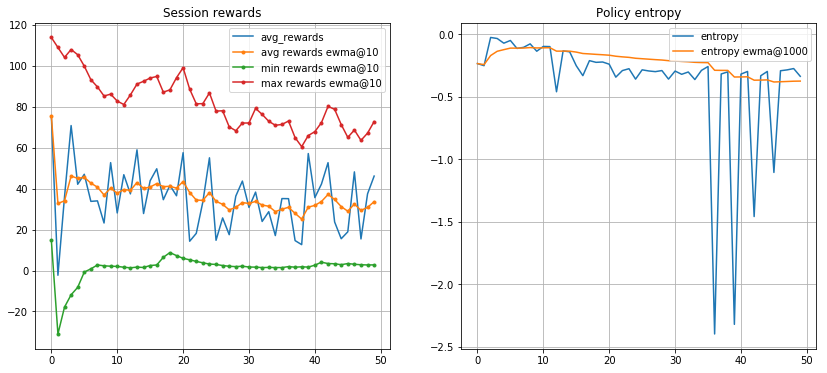

100%|██████████| 50/50 [10:42<00:00, 12.27s/it]


In [4]:
res = ac.train_and_display(n_iters=5001, n_games_per_plot_update=5 )

In [5]:
def get_optimal_action(state):
    direction = ( 1. - state ) 
    magnitude = min( 0.1, np.abs(direction) )
    action = magnitude * direction / ( np.abs(direction) + 1e-6 )
    return action

def get_value( env, state, policy, gamma ):
    # Set the starting state to the input state
    env.reset()
    env.state_vars = tmp_env.state_vars.__class__(state)
    
    done = False
    ctr = 0
    tot_reward = 0
    while not done:
        action = policy(state)
        state, reward, done, info = tmp_env.step(action)
        tot_reward += (gamma ** ctr ) * reward
        ctr += 1
    return tot_reward

def get_values( env, states, policy, gamma ):
    opt_vals = []
    for state in states:
        state = np.array( [ state ] , dtype=np.float32)
        val = get_value( env=tmp_env, state=state, policy=get_optimal_action, gamma=gamma  )
        opt_vals.append(val)
    return opt_vals

In [6]:
tmp_env = env_init_fun()
tmp_env._max_episode_steps = max_episode_steps
tmp_env.reset()

array([-3.1365633], dtype=float32)

### Compare the estimated value and action to the optimal value and policy

The chart on the left compares the optimal policy to the mean of the distribution for the estimated policy.

The chart on the right compares the value under the optimal policy to the estimated value.

W0107 11:56:34.574991 4376081856 base_layer.py:1814] Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W0107 11:56:35.960361 4376081856 base_layer.py:1814] Layer dense_2 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If 

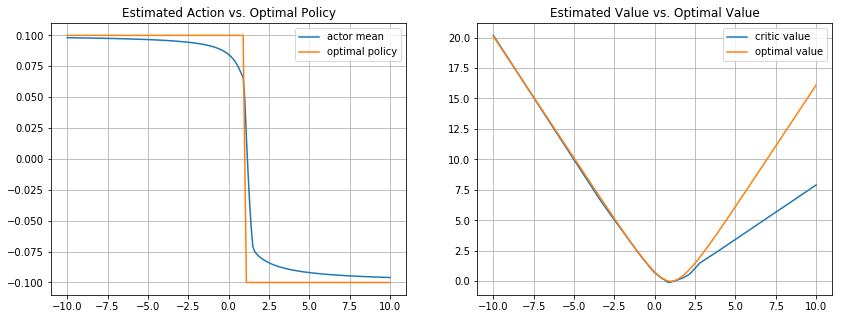

In [7]:
states = np.arange( -10, 10.001, 0.1 )

plt.figure(figsize=[14, 5])
plt.subplot(1, 2, 1)
C = 1 + tf.nn.relu( ac.actor.model.predict( states.reshape(-1, 1) ) )
dist = tfp.distributions.Beta( C[:,0], C[:,1] )
plt.plot( states, 0.2 * dist.mean() - 0.1, label='actor mean' ) 
plt.plot( states, [ get_optimal_action(a) for a in states ], label='optimal policy' )
plt.title("Estimated Action vs. Optimal Policy")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
opt_vals = get_values( env=tmp_env, states=states, policy=get_optimal_action, gamma=gamma )
plt.plot( states, ac.critic.model.predict( states.reshape(-1, 1) ), label='critic value' )
plt.plot(states, opt_vals, label='optimal value')
plt.title("Estimated Value vs. Optimal Value")
plt.grid()
plt.legend()
plt.show()

### Show how gamma affects the optimal value
The chart on the left shows that the value (under the optimal policy) increases with gamma.

The chart on the right shows how the total return is affected by choosing different actions in one particular state (x = 3.0). For the optimal action (action = -0.10), the total return is unaffected, but non-optimal actions lead to negative changes in total return. 

Note that for gamma = 1.0, there is no change in total return because any action can be undone as this formulation is time invariant. However, gamma < 1.0 ensures that collecting rewards as quickly as possible is the optimal strategy, and so non-optimal actions decrease the total return.

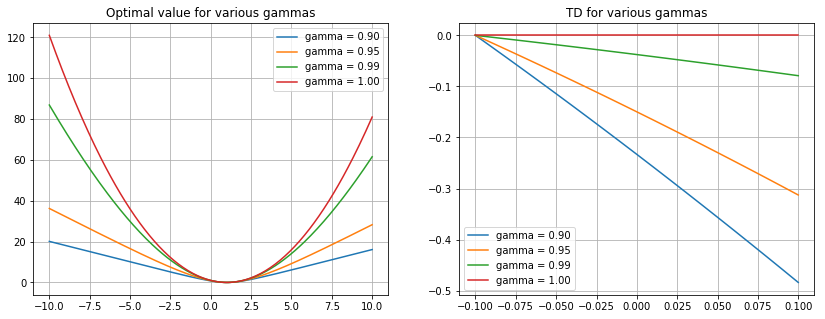

In [9]:
states = np.arange(-10, 10.01, 0.10 )
gammas = [ 0.9, 0.95, 0.99, 1 ]

plt.figure(figsize=[14, 5])
plt.subplot(1, 2, 1)
opt_vals = dict()
for g in gammas:
    ov = []
    for state in states:
        state = np.array( [state], dtype=np.float32)
        val = get_value( env=tmp_env, state=state, policy=get_optimal_action, gamma=g  )
        ov.append(val)
    opt_vals[g] = ov    
for g, ov in opt_vals.items():
    plt.plot( states, ov, label='gamma = {:.2f}'.format(g) )     
plt.title("Optimal value for various gammas")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
actions = np.arange(-0.10, 0.101, 0.01 )
initial_state = [3.]
for g in gammas:
    new_state_vals = []
    rewards = []
    old_state = np.array( initial_state, dtype=np.float32)
    old_state_val = get_value( env=tmp_env, state=old_state, policy=get_optimal_action, gamma=g  )    
    for action in actions:
        tmp_env.set_state(old_state)
        reward, new_state = tmp_env.calculate_reward(action)
        new_state_val = get_value( env=tmp_env, state=new_state, policy=get_optimal_action, gamma=g  )
        new_state_vals.append(new_state_val)
        rewards.append(reward)
    new_state_vals = np.array(new_state_vals)
    rewards = np.array(rewards)
    plt.plot( actions, rewards + g * new_state_vals - old_state_val, \
                                     label='gamma = {:.2f}'.format(g) )
plt.title("TD for various gammas")
plt.grid()
plt.legend()
plt.show()

### Show the reward distributions for games using the optimal policy

Text(0.5, 1.0, 'Rewards for optimal game play with gamma = 0.90')

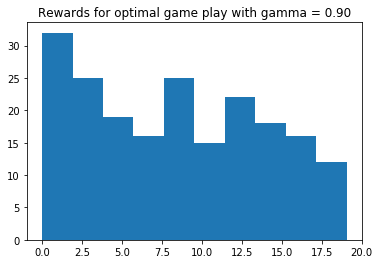

In [10]:
tmp_env = env_init_fun()
tmp_env._max_episode_steps = 500
n_games = 200 

game_rewards = []
state = tmp_env.reset()
for _ in range(n_games):
    total_reward = 0
    j = 0
    while True:
        action = get_optimal_action(state)
        
        state, reward, done, info = tmp_env.step(action)
        total_reward += (gamma ** j ) * reward
        if done: 
            state = tmp_env.reset()            
            break
        j += 1
    game_rewards.append( total_reward )
    
plt.hist( game_rewards )
plt.title("Rewards for optimal game play with gamma = {:.2f}".format(gamma) )